# Flatiron Health mBC: Relaxed trials with GBM crude

***OBJECTIVE:*** **Reproduce 3 landmark clinical trials in metastatic breast cancer. Inclusion criteria for these trials will be pragmatically relaxed to allow for entry of our real-world patients, many of which would not meet inclusion criteria in randomized controlled trials. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Preprocessing**

2. **In-silico trials:**
* PALOMA-2 
* PALOMA-3
* CLEOPATRA
* MONALEESA-2

## Part 1: Preprocessing

### 1.1 Import packages and create necessary functions

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
# Find index for value closest to input value. 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [4]:
# Calculates probability of survival at time t-months for risk groups. 
def psurv_t(low, med, high, t):
    low_t = low.survival_function_at_times(find_nearest(low.timeline, t)).values[0]*100
    med_t = med.survival_function_at_times(find_nearest(med.timeline, t)).values[0]*100
    high_t = high.survival_function_at_times(find_nearest(high.timeline, t)).values[0]*100
    pos_t = [low_t, med_t, high_t]
    return (pos_t)

In [5]:
# Calculates median overeall suvival for risk groups. 
def mos(low, med, high, comp):
    low_os = low.median_survival_time_
    med_os = med.median_survival_time_
    high_os = high.median_survival_time_
    comp_os = comp.median_survival_time_
    mos = [low_os, med_os, high_os, comp_os]
    return (mos)

In [6]:
# Calculates upper and lower 95% CI for median overall survival. 
def mos_ci(kmf):
    kmf_mos_low = (
        kmf.confidence_interval_[['KM_estimate_lower_0.95']]
        [kmf.confidence_interval_[['KM_estimate_lower_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_lower_0.95'], 0.5)]
        .idxmin()[0])

    kmf_mos_up = (
        kmf.confidence_interval_[['KM_estimate_upper_0.95']]
        [kmf.confidence_interval_[['KM_estimate_upper_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_upper_0.95'], 0.5)]
        .idxmin()[0])
    
    mos_ci = [kmf_mos_low, kmf_mos_up]
    return (mos_ci)

In [7]:
# Calculates upper and lower 95% CI for probability of survival at time t. 
def psurv_ci(kmf, t):
    kmf_psurv_ci_low = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][0]*100)

    kmf_psurv_ci_up = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][1]*100)
    
    psurv_ci = [kmf_psurv_ci_low, kmf_psurv_ci_up]
    return (psurv_ci)

In [8]:
# Calculate median overall survival or psurv error. 
def y_error(low_ci, med_ci, high_ci, surv_metric):
    error = [np.array([surv_metric[0] - low_ci[0],
                       surv_metric[1]- med_ci[0],
                       surv_metric[2] - high_ci[0]]),
               np.array([low_ci[1] - surv_metric[0],
                         med_ci[1] - surv_metric[1],
                         high_ci[1] - surv_metric[2]])]
    return(error)

In [9]:
# Cutoff decimlas to length n. 
def truncate(n, decimals = 0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

### 1.2 Process data 

In [10]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(25341, 25341)

In [11]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(6336, 6336)

In [12]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(31677, 31677)

In [13]:
crude_risk_score_df = pd.read_csv('crude_risk_score_df.csv')
row_ID(crude_risk_score_df)

(31677, 31677)

In [14]:
df = pd.merge(df, crude_risk_score_df, on = 'PatientID')
row_ID(df)

(31677, 31677)

In [15]:
df.to_csv('df_risk_crude.csv', index = False, header = True)

## Part 2: In silico trials 

### PALOMA-2: palbociclib plus letrozole vs. letrozole in hormone-sensitive metastatic breast cancer

**INCLUSION**
* Untreated metastatic breast cancer
* Received first line palbociclib and aromatase inhibitor or aromatase inhibitor alone
* Luteinizing hormone–releasing hormone agonist (leuprolide, goserelin, and triptorelin) is allowed in either arm
* ER-positive within [-90, +30] days of first-line treatment
* HER-2 negative within [-90, +30] days of first-line treatment

#### Palbociclib plus AI 

In [16]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [17]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [18]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [19]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Palbociclib')].LineName.value_counts().head(10)

Letrozole,Palbociclib                  2503
Fulvestrant,Palbociclib                1324
Anastrozole,Palbociclib                 466
Palbociclib                             261
Exemestane,Palbociclib                  123
Letrozole,Leuprolide,Palbociclib         98
Goserelin,Letrozole,Palbociclib          90
Fulvestrant,Letrozole,Palbociclib        40
Anastrozole,Fulvestrant,Palbociclib      37
Palbociclib,Tamoxifen                    31
Name: LineName, dtype: int64

In [20]:
# Of note, LH releasing hormone agonist (leuprolide, goserelin, and triptorelin) not excluded
ai = [
    'Anastrozole',
    'Letrozole',
    'Exemestane']

exc = [
    'Capecitabine',
    'Carboplatin',
    'Cisplatin',
    'Cyclophosphamide',
    'Cytarabine Liposomal',
    'Decitabine',
    'Docetaxel',
    'Doxorubicin',
    'Doxorubicin Pegylated Liposomal',
    'Eribulin',
    'Etoposide',
    'Fluorouracil',
    'Gemcitabine',
    'Hydroxyurea',
    'Leucovorin',
    'Methotrexate',
    'Oxaliplatin',
    'Paclitaxel',
    'Paclitaxel Protein-Bound',
    'Vinorelbine',
    'Nivolumab',
    'Pembrolizumab',
    'Abemaciclib',
    'Alpelisib',
    'Fulvestrant',
    'Ribociclib',
    'Tamoxifen',
    'Carfilzomib',
    'Daratumumab',
    'Everolimus',
    'Imatinib',
    'Lapatinib',
    'Lenalidomide',
    'Neratinib',
    'Olaparib',
    'Pazopanib',
    'Pertuzumab',
    'Rituximab',
    'Sorafenib',
    'Toremifene',
    'Trastuzumab',
    'Clinical Study Drug',
]

In [21]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                line_therapy_fl['LineName'].str.contains('Palbociclib') &
                ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(30)

Letrozole,Palbociclib                  2503
Anastrozole,Palbociclib                 466
Exemestane,Palbociclib                  123
Letrozole,Leuprolide,Palbociclib         98
Goserelin,Letrozole,Palbociclib          90
Anastrozole,Goserelin,Palbociclib        17
Anastrozole,Leuprolide,Palbociclib       17
Letrozole,Palbociclib,Triptorelin         5
Anastrozole,Palbociclib,Triptorelin       4
Exemestane,Goserelin,Palbociclib          4
Exemestane,Leuprolide,Palbociclib         3
Name: LineName, dtype: int64

In [22]:
let_palb = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                    line_therapy_fl['LineName'].str.contains('Palbociclib') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    [['PatientID', 'StartDate']]
)

In [23]:
row_ID(let_palb)

(3330, 3330)

In [24]:
let_palb.loc[:,'let_palb'] = 1

#### AI

In [25]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Letrozole')].LineName.value_counts().head(10)

Letrozole                            2536
Letrozole,Palbociclib                2503
Letrozole,Ribociclib                  229
Abemaciclib,Letrozole                 190
Letrozole,Leuprolide,Palbociclib       98
Goserelin,Letrozole,Palbociclib        90
Fulvestrant,Letrozole                  64
Letrozole,Trastuzumab                  59
Fulvestrant,Letrozole,Palbociclib      40
Letrozole,Leuprolide                   40
Name: LineName, dtype: int64

In [26]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                ~line_therapy_fl['LineName'].str.contains('Palbociclib') &
                ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(40)

Anastrozole                      2943
Letrozole                        2536
Exemestane                        780
Letrozole,Leuprolide               40
Anastrozole,Leuprolide             35
Goserelin,Letrozole                26
Anastrozole,Goserelin              20
Exemestane,Goserelin                7
Exemestane,Leuprolide               4
Anastrozole,Triptorelin             2
Letrozole,Medroxyprogesterone       1
Letrozole,Triptorelin               1
Anastrozole,Megestrol               1
Name: LineName, dtype: int64

In [27]:
let = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                    ~line_therapy_fl['LineName'].str.contains('Palbociclib') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    [['PatientID', 'StartDate']]
)

In [28]:
row_ID(let)

(6396, 6396)

In [29]:
let.loc[:,'let_palb'] = 0

In [30]:
paloma2 = pd.concat([let_palb, let])

In [31]:
row_ID(paloma2)

(9726, 9726)

In [32]:
paloma2 = pd.merge(df_full, paloma2, on = 'PatientID', how = 'inner')

In [33]:
row_ID(paloma2)

(9726, 9726)

In [34]:
paloma2['StartDate'] = pd.to_datetime(paloma2['StartDate'])

#### ER-positive and HER-2 negative 

In [35]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [36]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(paloma2['PatientID'])]

In [37]:
row_ID(biomarkers)

(69754, 9662)

In [38]:
biomarkers = pd.merge(biomarkers, paloma2[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [39]:
row_ID(biomarkers)

(69754, 9662)

In [40]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [41]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [42]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [43]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [44]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [45]:
er_status = (
    biomarkers
    .query('BiomarkerName == "ER"')
    .query('date_diff <= 30 and date_diff >= -90')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'er'})
   )

In [46]:
row_ID(er_status)

(6016, 6016)

In [47]:
her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30 and date_diff >= -90')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [48]:
row_ID(her2_status)

(5607, 5607)

In [49]:
paloma2 = pd.merge(paloma2, er_status, on  = 'PatientID', how = 'left')

In [50]:
row_ID(paloma2)

(9726, 9726)

In [51]:
paloma2 = pd.merge(paloma2, her2_status, on  = 'PatientID', how = 'left')

In [52]:
row_ID(paloma2)

(9726, 9726)

In [53]:
her2_neg = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'IHC equivocal (2+)',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'FISH equivocal',
            'Equivocal NOS',
            'NGS equivocal (ERBB2 amplification equivocal)']

paloma2 = (
    paloma2
    .query('er == "Positive"')
    .query('her2== @her2_neg')
)

In [54]:
row_ID(paloma2)

(4842, 4842)

#### Time from treatment to progression/death or censor 

In [55]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [56]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [57]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [58]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [59]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [60]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [61]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [62]:
row_ID(mortality)

(31677, 31677)

In [63]:
paloma2 = pd.merge(paloma2, mortality, on = 'PatientID', how = 'inner')

In [64]:
row_ID(paloma2)

(4842, 4842)

In [65]:
progression = pd.read_csv ('Enhanced_MetBreastProgression.csv')

In [66]:
progression = progression[progression['PatientID'].isin(paloma2['PatientID'])][['PatientID', 'ProgressionDate']]

In [67]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [68]:
progression = (
    progression
    .sort_values(['PatientID', 'ProgressionDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [69]:
row_ID(progression)

(4840, 4840)

In [70]:
paloma2 = pd.merge(paloma2, progression, on = 'PatientID', how = 'left')

In [71]:
row_ID(paloma2)

(4842, 4842)

In [72]:
# Percent without progression date
len(paloma2.query('ProgressionDate.isna()', engine = 'python'))/len(paloma2)

0.4012804626187526

In [73]:
conditions = [
    (paloma2.ProgressionDate.notna()),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 1)),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 0))]

choices = [
    (paloma2['ProgressionDate'] - paloma2['StartDate']).dt.days,
    (paloma2['death_date'] - paloma2['StartDate']).dt.days,
    (paloma2['last_activity'] - paloma2['StartDate']).dt.days]

paloma2.loc[:, 'time_prog_treatment'] = np.select(conditions, choices)

In [74]:
paloma2 = paloma2.query('time_prog_treatment >= 0')

In [75]:
len(paloma2)

4734

In [76]:
conditions = [
    (paloma2.ProgressionDate.notna()),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 1)),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 0))]

choices = [1, 1, 0]

paloma2.loc[:, 'pfs_status'] = np.select(conditions, choices)

#### Patient count 

In [77]:
low_cutoff_paloma2 = paloma2.risk_score.quantile(1/3)

In [78]:
high_cutoff_paloma2 = paloma2.risk_score.quantile(2/3)

In [79]:
print('Palbociclib plus letrozole total:',  paloma2.query('let_palb == 1').shape[0])
print('High risk:', paloma2.query('let_palb == 1').query('risk_score >= @high_cutoff_paloma2').shape[0])
print('Med risk:', paloma2.query('let_palb == 1').query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2').shape[0])
print('Low risk:', paloma2.query('let_palb == 1').query('risk_score <= @low_cutoff_paloma2').shape[0])

Palbociclib plus letrozole total: 2137
High risk: 615
Med risk: 681
Low risk: 841


In [80]:
print('Letrozole:',  paloma2.query('let_palb == 0').shape[0])
print('High risk:', paloma2.query('let_palb == 0').query('risk_score >= @high_cutoff_paloma2').shape[0])
print('Med risk:', paloma2.query('let_palb == 0').query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2').shape[0])
print('Low risk:', paloma2.query('let_palb == 0').query('risk_score <= @low_cutoff_paloma2').shape[0])

Letrozole: 2597
High risk: 963
Med risk: 897
Low risk: 737


In [81]:
data = {'low': [low_cutoff_paloma2],
        'high': [high_cutoff_paloma2]}

risk_cutoff_breast = pd.DataFrame(data = data, index = ['paloma2'])

#### PFS curves with covariate balancing 

In [82]:
paloma2 = paloma2.set_index('PatientID')

In [83]:
conditions = [
    (paloma2['thorax_met'] == 1) |
    (paloma2['liver_met'] == 1) |
    (paloma2['cns_met'] == 1) |
    (paloma2['peritoneum_met'] == 1) |
    (paloma2['other_met'] == 1),
    (paloma2['bone_met'] == 0) &
    (paloma2['thorax_met'] == 0) &
    (paloma2['lymph_met'] == 0) &
    (paloma2['liver_met'] == 0) &
    (paloma2['cns_met'] == 0) &
    (paloma2['skin_met'] == 0) &
    (paloma2['peritoneum_met'] == 0) &
    (paloma2['other_met'] == 0)
]

choices = ['visceral', 'unknown']

paloma2['met_site'] = np.select(conditions, choices, default = 'nonvisceral')

In [84]:
paloma2['met_cat'] = pd.cut(paloma2['met_year'],
                            bins = [2010, 2016, float('inf')],
                            labels = ['11-16', '17-22'])

In [85]:
conditions = [
    ((paloma2['ecog_diagnosis'] == "1.0") | (paloma2['ecog_diagnosis'] == "0.0")),  
    ((paloma2['ecog_diagnosis'] == "2.0") | (paloma2['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

paloma2['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [86]:
paloma2_iptw = paloma2.filter(items = ['pfs_status',
                                       'time_prog_treatment',
                                       'let_palb',
                                       'age',
                                       'gender',
                                       'race',
                                       'p_type',
                                       'delta_met_diagnosis',
                                       'met_cat',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ses',
                                       'ecog_2',
                                       'met_site',
                                       'risk_score'])

In [87]:
paloma2_iptw.dtypes

pfs_status                int64
time_prog_treatment     float64
let_palb                  int64
age                       int64
gender                   object
race                     object
p_type                   object
delta_met_diagnosis       int64
met_cat                category
commercial              float64
medicare                float64
medicaid                float64
ses                     float64
ecog_2                   object
met_site                 object
risk_score              float64
dtype: object

In [88]:
to_be_categorical = list(paloma2_iptw.select_dtypes(include = ['object']).columns)

In [89]:
to_be_categorical

['gender', 'race', 'p_type', 'ecog_2', 'met_site']

In [90]:
to_be_categorical.append('met_cat')

In [91]:
to_be_categorical.append('ses')

In [92]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    paloma2_iptw[x] = paloma2_iptw[x].astype('category')

In [93]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [94]:
# List of categorical features.
categorical_features = list(paloma2_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [95]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [96]:
paloma2_iptw_low = (
    paloma2_iptw
    .query('risk_score <= @low_cutoff_paloma2')
    .drop(columns = ['risk_score']))

paloma2_iptw_med = (
    paloma2_iptw
    .query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2')
    .drop(columns = ['risk_score']))

paloma2_iptw_high = (
    paloma2_iptw
    .query('risk_score >= @high_cutoff_paloma2')
    .drop(columns = ['risk_score']))

paloma2_iptw_all = (
    paloma2_iptw
    .drop(columns = ['risk_score']))

In [97]:
paloma2_low_x = preprocessor.fit_transform(paloma2_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site']))

paloma2_med_x = preprocessor.fit_transform(paloma2_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site']))

paloma2_high_x = preprocessor.fit_transform(paloma2_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ses',
                                                                              'ecog_2',
                                                                              'met_site']))

paloma2_all_x = preprocessor.fit_transform(paloma2_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site']))

In [98]:
lr_paloma2_low = LogisticRegression(max_iter = 1000)
lr_paloma2_low.fit(paloma2_low_x, paloma2_iptw_low['let_palb'])

LogisticRegression(max_iter=1000)

In [99]:
lr_paloma2_med = LogisticRegression(max_iter = 1000)
lr_paloma2_med.fit(paloma2_med_x, paloma2_iptw_med['let_palb'])

LogisticRegression(max_iter=1000)

In [100]:
lr_paloma2_high = LogisticRegression(max_iter = 1000)
lr_paloma2_high.fit(paloma2_high_x, paloma2_iptw_high['let_palb'])

LogisticRegression(max_iter=1000)

In [101]:
lr_paloma2_all = LogisticRegression(max_iter = 1000)
lr_paloma2_all.fit(paloma2_all_x, paloma2_iptw_all['let_palb'])

LogisticRegression(max_iter=1000)

In [102]:
pred_low = lr_paloma2_low.predict_proba(paloma2_low_x)
pred_med = lr_paloma2_med.predict_proba(paloma2_med_x)
pred_high = lr_paloma2_high.predict_proba(paloma2_high_x)
pred_all = lr_paloma2_all.predict_proba(paloma2_all_x)

In [103]:
paloma2_iptw_low['ps'] = pred_low[:, 1]
paloma2_iptw_med['ps'] = pred_med[:, 1]
paloma2_iptw_high['ps'] = pred_high[:, 1]
paloma2_iptw_all['ps'] = pred_all[:, 1]

In [104]:
paloma2_iptw_low['weight'] = (
    np.where(paloma2_iptw_low['let_palb'] == 1, 1/paloma2_iptw_low['ps'], 1/(1 - paloma2_iptw_low['ps'])))

paloma2_iptw_med['weight'] = (
    np.where(paloma2_iptw_med['let_palb'] == 1, 1/paloma2_iptw_med['ps'], 1/(1 - paloma2_iptw_med['ps'])))

paloma2_iptw_high['weight'] = (
    np.where(paloma2_iptw_high['let_palb'] == 1, 1/paloma2_iptw_high['ps'], 1/(1 - paloma2_iptw_high['ps'])))

paloma2_iptw_all['weight'] = (
    np.where(paloma2_iptw_all['let_palb'] == 1, 1/paloma2_iptw_all['ps'], 1/(1 - paloma2_iptw_all['ps'])))

In [105]:
# Low KM curves
kmf_low_plet_paloma2_iptw = KaplanMeierFitter()
kmf_low_let_paloma2_iptw = KaplanMeierFitter()

kmf_low_plet_paloma2_iptw.fit(
    paloma2_iptw_low.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_low.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_low.query('let_palb == 1')['weight'])

kmf_low_let_paloma2_iptw.fit(
    paloma2_iptw_low.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_low.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_low.query('let_palb == 0')['weight'])

# Med KM curves
kmf_med_plet_paloma2_iptw = KaplanMeierFitter()
kmf_med_let_paloma2_iptw = KaplanMeierFitter()

kmf_med_plet_paloma2_iptw.fit(
    paloma2_iptw_med.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_med.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_med.query('let_palb == 1')['weight'])

kmf_med_let_paloma2_iptw.fit(
    paloma2_iptw_med.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_med.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_med.query('let_palb == 0')['weight'])

# High KM curves 
kmf_high_plet_paloma2_iptw = KaplanMeierFitter()
kmf_high_let_paloma2_iptw = KaplanMeierFitter()

kmf_high_plet_paloma2_iptw.fit(
    paloma2_iptw_high.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_high.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_high.query('let_palb == 1')['weight'])

kmf_high_let_paloma2_iptw.fit(
    paloma2_iptw_high.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_high.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_high.query('let_palb == 0')['weight'])

# All KM curves 
kmf_all_plet_paloma2_iptw = KaplanMeierFitter()
kmf_all_let_paloma2_iptw = KaplanMeierFitter()

kmf_all_plet_paloma2_iptw.fit(
    paloma2_iptw_all.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_all.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_all.query('let_palb == 1')['weight'])

kmf_all_let_paloma2_iptw.fit(
    paloma2_iptw_all.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_all.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_all.query('let_palb == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4776.11 total observations, 1116.7 right-censored observations>

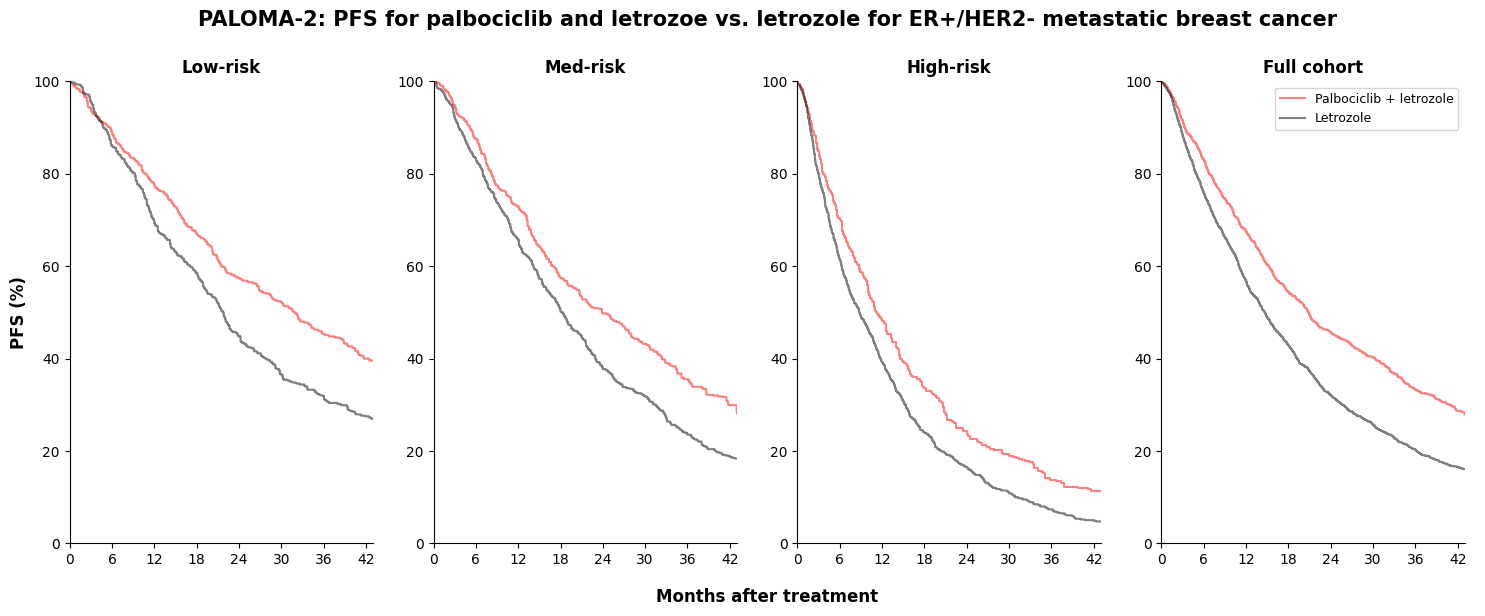

In [106]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_plet_paloma2_iptw.timeline, kmf_low_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_let_paloma2_iptw.timeline, kmf_low_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('PFS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_plet_paloma2_iptw.timeline, kmf_med_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_let_paloma2_iptw.timeline, kmf_med_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_plet_paloma2_iptw.timeline, kmf_high_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_let_paloma2_iptw.timeline, kmf_high_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_plet_paloma2_iptw.timeline, kmf_all_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Palbociclib + letrozole')

plt.step(kmf_all_let_paloma2_iptw.timeline, kmf_all_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Letrozole')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-2: PFS for palbociclib and letrozoe vs. letrozole for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [107]:
plet_paloma2_12_pfs = psurv_t(kmf_low_plet_paloma2_iptw,
                              kmf_med_plet_paloma2_iptw,
                              kmf_high_plet_paloma2_iptw,
                              12)

let_paloma2_12_pfs = psurv_t(kmf_low_let_paloma2_iptw,
                             kmf_med_let_paloma2_iptw,
                             kmf_high_let_paloma2_iptw,
                             12)

plet_paloma2_24_pfs = psurv_t(kmf_low_plet_paloma2_iptw,
                              kmf_med_plet_paloma2_iptw,
                              kmf_high_plet_paloma2_iptw,
                              24)

let_paloma2_24_pfs = psurv_t(kmf_low_let_paloma2_iptw,
                             kmf_med_let_paloma2_iptw,
                             kmf_high_let_paloma2_iptw,
                             24)

plet_paloma2_median_pfs = mos(kmf_low_plet_paloma2_iptw,
                              kmf_med_plet_paloma2_iptw,
                              kmf_high_plet_paloma2_iptw,
                              kmf_all_plet_paloma2_iptw)

let_paloma2_median_pfs = mos(kmf_low_let_paloma2_iptw,
                             kmf_med_let_paloma2_iptw,
                             kmf_high_let_paloma2_iptw,
                             kmf_all_let_paloma2_iptw)

In [108]:
print('All, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[3], 3))
print('All, letrozole: ',truncate(let_paloma2_median_pfs[3], 3))

print('Low, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[0], 3))
print('Low, letrozole: ',truncate(let_paloma2_median_pfs[0], 3))

print('Med, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[1], 3))
print('Med, letrozole: ',truncate(let_paloma2_median_pfs[1], 3))

print('High, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[2], 3))
print('High, letrozole: ',truncate(let_paloma2_median_pfs[2], 3))

All, palbo + letrozole:  20.933
All, letrozole:  14.766
Low, palbo + letrozole:  31.933
Low, letrozole:  21.833
Med, palbo + letrozole:  24.0
Med, letrozole:  18.4
High, palbo + letrozole:  11.3
High, letrozole:  8.833


In [109]:
plet_paloma2_low_12_ci = psurv_ci(kmf_low_plet_paloma2_iptw, 12)
plet_paloma2_med_12_ci = psurv_ci(kmf_med_plet_paloma2_iptw, 12)
plet_paloma2_high_12_ci = psurv_ci(kmf_high_plet_paloma2_iptw, 12)

y_error_plet_paloma2_12 = y_error(plet_paloma2_low_12_ci,
                                  plet_paloma2_med_12_ci,
                                  plet_paloma2_high_12_ci,
                                  plet_paloma2_12_pfs)

In [110]:
let_paloma2_low_12_ci = psurv_ci(kmf_low_let_paloma2_iptw, 12)
let_paloma2_med_12_ci = psurv_ci(kmf_med_let_paloma2_iptw, 12)
let_paloma2_high_12_ci = psurv_ci(kmf_high_let_paloma2_iptw, 12)

y_error_let_paloma2_12 = y_error(let_paloma2_low_12_ci,
                                 let_paloma2_med_12_ci,
                                 let_paloma2_high_12_ci,
                                 let_paloma2_12_pfs)

In [111]:
plet_paloma2_low_24_ci = psurv_ci(kmf_low_plet_paloma2_iptw, 24)
plet_paloma2_med_24_ci = psurv_ci(kmf_med_plet_paloma2_iptw, 24)
plet_paloma2_high_24_ci = psurv_ci(kmf_high_plet_paloma2_iptw, 24)

y_error_plet_paloma2_24 = y_error(plet_paloma2_low_24_ci,
                                  plet_paloma2_med_24_ci,
                                  plet_paloma2_high_24_ci,
                                  plet_paloma2_24_pfs)

In [112]:
let_paloma2_low_24_ci = psurv_ci(kmf_low_let_paloma2_iptw, 24)
let_paloma2_med_24_ci = psurv_ci(kmf_med_let_paloma2_iptw, 24)
let_paloma2_high_24_ci = psurv_ci(kmf_high_let_paloma2_iptw, 24)

y_error_let_paloma2_24 = y_error(let_paloma2_low_24_ci,
                                 let_paloma2_med_24_ci,
                                 let_paloma2_high_24_ci,
                                 let_paloma2_24_pfs)

In [113]:
plet_paloma2_low_mpfs_ci = mos_ci(kmf_low_plet_paloma2_iptw)
plet_paloma2_med_mpfs_ci = mos_ci(kmf_med_plet_paloma2_iptw)
plet_paloma2_high_mpfs_ci = mos_ci(kmf_high_plet_paloma2_iptw)

y_error_plet_paloma2_mpfs = y_error(plet_paloma2_low_mpfs_ci,
                                    plet_paloma2_med_mpfs_ci,
                                    plet_paloma2_high_mpfs_ci,
                                    plet_paloma2_median_pfs)

In [114]:
let_paloma2_low_mpfs_ci = mos_ci(kmf_low_let_paloma2_iptw)
let_paloma2_med_mpfs_ci = mos_ci(kmf_med_let_paloma2_iptw)
let_paloma2_high_mpfs_ci = mos_ci(kmf_high_let_paloma2_iptw)

y_error_let_paloma2_mpfs = y_error(let_paloma2_low_mpfs_ci,
                                   let_paloma2_med_mpfs_ci,
                                   let_paloma2_high_mpfs_ci,
                                   let_paloma2_median_pfs)

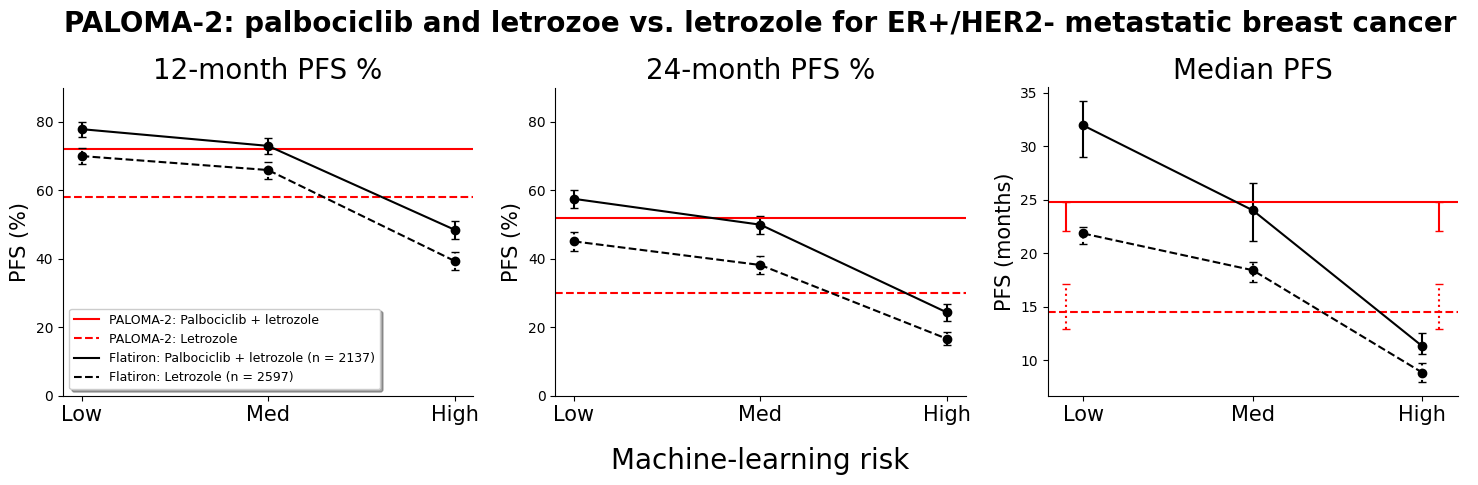

In [115]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, plet_paloma2_12_pfs, yerr = y_error_plet_paloma2_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 72, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, let_paloma2_12_pfs, yerr = y_error_let_paloma2_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 58, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('PFS (%)', size = 15)

plt.title('12-month PFS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, plet_paloma2_24_pfs, yerr = y_error_plet_paloma2_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 52, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, let_paloma2_24_pfs, yerr = y_error_let_paloma2_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 30, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('PFS (%)', size = 15)

plt.title('24-month PFS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, plet_paloma2_median_pfs[0:3], yerr = y_error_plet_paloma2_mpfs, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 24.8, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 24.8, yerr=[np.array([24.8-22.1]), np.array([24.8-24.8])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, let_paloma2_median_pfs[0:3], yerr = y_error_let_paloma2_mpfs, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 14.5, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 14.5, yerr=[np.array([14.5-12.9]), np.array([17.1-14.5])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('PFS (months)', size = 15)

plt.title('Median PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('PALOMA-2: palbociclib and letrozoe vs. letrozole for ER+/HER2- metastatic breast cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'PALOMA-2: Palbociclib + letrozole'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'PALOMA-2: Letrozole'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Palbociclib + letrozole (n = {})'.format(paloma2.query('let_palb == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Letrozole (n = {})'.format(paloma2.query('let_palb == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

plt.savefig('paloma2_summary_rc.png', bbox_inches = 'tight')

plt.show()

### PALOMA-3: palbociclib plus fulvestrant vs. fulvestrant in hormone-sensitive metastatic breast cancer that had previously progressed on endocrine therapy

**INCLUSION**
* Received first line estrogen therapy +/- one line of chemotherapy 
* Received second line palbociclib plus fulvestrant or fulvestrant alone 
* Did not receive CDK 4/6 inhibitor, fulvestrant, or everolimus in earlier lines
* ER/PR positive and HER-2 negative within (-inf, +30] days of start of treatment

#### 1. First line endorcine therapy + chemotherapy, second line fulvestrant +/- palbociclib

In [116]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [117]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [118]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [119]:
et = [
    'Anastrozole',
    'Letrozole',
    'Exemestane',
    'Tamoxifen',
    'Leuprolide',
    'Goserelin',
    'Triptorelin',
    'Buserelin']

chemo = [
    'Capecitabine',
    'Carboplatin',
    'Cyclophosphamide',
    'Docetaxel',
    'Eribulin',
    'Gemcitabine',
    'Paclitaxel',
    'Paclitaxel Protein-Bound',
    'Vinorelbine']

exc =[
    'Abemaciclib',
    'Palbociclib',
    'Ribociclib',
    'Fulvestrant',
    'Everolimus',
    'Clinical Study Drug']

In [120]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(et)) 
                & line_therapy_fl['LineName'].str.contains('|'.join(chemo))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Capecitabine,Letrozole                        31
Anastrozole,Capecitabine                      25
Anastrozole,Paclitaxel                        18
Letrozole,Paclitaxel Protein-Bound            17
Anastrozole,Paclitaxel Protein-Bound          14
Capecitabine,Tamoxifen                        14
Capecitabine,Exemestane                       13
Letrozole,Paclitaxel                          13
Docetaxel,Letrozole,Pertuzumab,Trastuzumab    11
Paclitaxel,Tamoxifen                          11
Name: LineName, dtype: int64

In [121]:
etchemo_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [122]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(etchemo_id)]
    .query('LineNumber == 2'))

In [123]:
etchemo_pf = (
    line_therapy_sec
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [124]:
row_ID(etchemo_pf)

(16, 16)

In [125]:
etchemo_f = (
    line_therapy_sec
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [126]:
row_ID(etchemo_pf)

(16, 16)

#### 2. First line endocrine therapy,  second line chemotherapy, third line palbociclib + fulvestrant

In [127]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(et)) 
                & ~line_therapy_fl['LineName'].str.contains('|'.join(chemo))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Anastrozole                2943
Letrozole                  2536
Tamoxifen                  1305
Exemestane                  780
Leuprolide                   77
Anastrozole,Trastuzumab      66
Goserelin                    60
Letrozole,Trastuzumab        59
Leuprolide,Tamoxifen         56
Letrozole,Leuprolide         40
Name: LineName, dtype: int64

In [128]:
et_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [129]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
)

In [130]:
et_chemo_id = (
    line_therapy_sec
    [line_therapy_sec['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_sec['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [131]:
et_chemo_pf = (
    line_therapy[line_therapy['PatientID'].isin(et_chemo_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [132]:
row_ID(et_chemo_pf)

(34, 34)

In [133]:
et_chemo_f = (
    line_therapy[line_therapy['PatientID'].isin(et_chemo_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [134]:
row_ID(et_chemo_f)

(57, 57)

#### 3. First line chemotherapy, second line endocrine therapy, third line palbociclib + fulvestrant

In [135]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(chemo)) 
                & ~line_therapy_fl['LineName'].str.contains('|'.join(et))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Capecitabine                             1324
Cyclophosphamide,Doxorubicin              690
Docetaxel,Pertuzumab,Trastuzumab          676
Paclitaxel                                589
Paclitaxel Protein-Bound                  584
Carboplatin,Gemcitabine                   407
Paclitaxel,Pertuzumab,Trastuzumab         289
Eribulin                                  261
Carboplatin,Paclitaxel                    250
Atezolizumab,Paclitaxel Protein-Bound     226
Name: LineName, dtype: int64

In [136]:
chemo_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [137]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(chemo_id)]
    .query('LineNumber == 2')
)

In [138]:
chemo_et_id = (
    line_therapy_sec
    [line_therapy_sec['LineName'].str.contains('|'.join(et))
     & ~line_therapy_sec['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [139]:
chemo_et_pf = (
    line_therapy[line_therapy['PatientID'].isin(chemo_et_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [140]:
row_ID(chemo_et_pf)

(39, 39)

In [141]:
chemo_et_f = (
    line_therapy[line_therapy['PatientID'].isin(chemo_et_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [142]:
row_ID(chemo_et_f)

(43, 43)

#### 4. First line endocrine therapy, second line palbociclib + fulvestrant

In [143]:
et_pf = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [144]:
row_ID(et_pf)

(440, 440)

In [145]:
et_f = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [146]:
row_ID(et_f)

(786, 786)

In [147]:
paloma3_pf = pd.concat([etchemo_pf, et_chemo_pf, chemo_et_pf, et_pf])

In [148]:
paloma3_pf.loc[:, 'pfulv'] = 1

In [149]:
row_ID(paloma3_pf)

(529, 529)

In [150]:
paloma3_f = pd.concat([etchemo_f, et_chemo_f, chemo_et_f, et_f])

In [151]:
paloma3_f.loc[:, 'pfulv'] = 0

In [152]:
row_ID(paloma3_f)

(902, 902)

In [153]:
paloma3 = pd.concat([paloma3_pf, paloma3_f])

In [154]:
row_ID(paloma3)

(1431, 1431)

In [155]:
paloma3 = pd.merge(paloma3, df_full, on = 'PatientID', how = 'inner')

In [156]:
row_ID(paloma3)

(1431, 1431)

In [157]:
paloma3['StartDate'] = pd.to_datetime(paloma3['StartDate'])

#### ER- or PR-positive and HER-2 negative 

In [158]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [159]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(paloma3['PatientID'])]

In [160]:
row_ID(biomarkers)

(10689, 1426)

In [161]:
biomarkers = pd.merge(biomarkers, paloma3[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [162]:
row_ID(biomarkers)

(10689, 1426)

In [163]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [164]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [165]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [166]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [167]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [168]:
er_status = (
    biomarkers
    .query('BiomarkerName == "ER"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'er'})
   )

In [169]:
row_ID(er_status)

(1293, 1293)

In [170]:
pr_status = (
    biomarkers
    .query('BiomarkerName == "PR"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'pr'})
   )

In [171]:
row_ID(pr_status)

(1253, 1253)

In [172]:
her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [173]:
row_ID(her2_status)

(1245, 1245)

In [174]:
paloma3 = pd.merge(paloma3, er_status, on  = 'PatientID', how = 'left')

In [175]:
row_ID(paloma3)

(1431, 1431)

In [176]:
paloma3 = pd.merge(paloma3, pr_status, on  = 'PatientID', how = 'left')

In [177]:
row_ID(paloma3)

(1431, 1431)

In [178]:
paloma3 = pd.merge(paloma3, her2_status, on  = 'PatientID', how = 'left')

In [179]:
row_ID(paloma3)

(1431, 1431)

In [180]:
her2_neg = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'IHC equivocal (2+)',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'FISH equivocal',
            'Equivocal NOS',
            'NGS equivocal (ERBB2 amplification equivocal)']

paloma3 = (
    paloma3
    .query('er == "Positive" or pr == "Positive"')
    .query('her2== @her2_neg')
)

In [181]:
row_ID(paloma3)

(1161, 1161)

#### Time from treatment to progression/death or censor 

In [182]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [183]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [184]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [185]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [186]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [187]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [188]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [189]:
row_ID(mortality)

(31677, 31677)

In [190]:
paloma3 = pd.merge(paloma3, mortality, on = 'PatientID', how = 'left')

In [191]:
row_ID(paloma3)

(1161, 1161)

In [192]:
conditions = [
    (paloma3['death_status'] == 1),
    (paloma3['death_status'] == 0)]

choices = [
    (paloma3['death_date'] - paloma3['StartDate']).dt.days,
    (paloma3['last_activity'] - paloma3['StartDate']).dt.days]

paloma3.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [193]:
paloma3 = paloma3.query('timerisk_treatment >= 0')

#### Patient count 

In [194]:
low_cutoff_paloma3 = paloma3.risk_score.quantile(1/3)

In [195]:
high_cutoff_paloma3 = paloma3.risk_score.quantile(2/3)

In [196]:
print('Palobociclib plus fulvestrant total:',  paloma3.query('pfulv == 1').shape[0])
print('High risk:', paloma3.query('pfulv == 1').query('risk_score >= @high_cutoff_paloma3').shape[0])
print('Med risk:', paloma3.query('pfulv == 1').query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3').shape[0])
print('Low risk:', paloma3.query('pfulv == 1').query('risk_score <= @low_cutoff_paloma3').shape[0])

Palobociclib plus fulvestrant total: 465
High risk: 148
Med risk: 150
Low risk: 167


In [197]:
print('Fulvestrant total:',  paloma3.query('pfulv == 0').shape[0])
print('High risk:', paloma3.query('pfulv == 0').query('risk_score >= @high_cutoff_paloma3').shape[0])
print('Med risk:', paloma3.query('pfulv == 0').query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3').shape[0])
print('Low risk:', paloma3.query('pfulv == 0').query('risk_score <= @low_cutoff_paloma3').shape[0])

Fulvestrant total: 696
High risk: 239
Med risk: 237
Low risk: 220


In [198]:
risk_cutoff_breast.loc['paloma3'] = [low_cutoff_paloma3, high_cutoff_paloma3]

#### Survival curves with covariate balancing 

In [199]:
paloma3 = paloma3.set_index('PatientID')

In [200]:
conditions = [
    (paloma3['thorax_met'] == 1) |
    (paloma3['liver_met'] == 1) |
    (paloma3['cns_met'] == 1) |
    (paloma3['peritoneum_met'] == 1) |
    (paloma3['other_met'] == 1),
    (paloma3['bone_met'] == 0) &
    (paloma3['thorax_met'] == 0) &
    (paloma3['lymph_met'] == 0) &
    (paloma3['liver_met'] == 0) &
    (paloma3['cns_met'] == 0) &
    (paloma3['skin_met'] == 0) &
    (paloma3['peritoneum_met'] == 0) &
    (paloma3['other_met'] == 0)
]

choices = ['visceral', 'unknown']

paloma3['met_site'] = np.select(conditions, choices, default = 'nonvisceral')

In [201]:
paloma3['met_cat'] = pd.cut(paloma3['met_year'],
                            bins = [2010, 2016, float('inf')],
                            labels = ['11-16', '17-22'])

In [202]:
conditions = [
    ((paloma3['ecog_diagnosis'] == "1.0") | (paloma3['ecog_diagnosis'] == "0.0")),  
    ((paloma3['ecog_diagnosis'] == "2.0") | (paloma3['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

paloma3['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [203]:
paloma3_iptw = paloma3.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pfulv',
                                       'age',
                                       'gender',
                                       'race',
                                       'p_type',
                                       'delta_met_diagnosis',
                                       'met_cat',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ses',
                                       'ecog_2',
                                       'met_site',
                                       'risk_score'])

In [204]:
paloma3_iptw.dtypes

death_status               bool
timerisk_treatment      float64
pfulv                     int64
age                       int64
gender                   object
race                     object
p_type                   object
delta_met_diagnosis       int64
met_cat                category
commercial              float64
medicare                float64
medicaid                float64
ses                     float64
ecog_2                   object
met_site                 object
risk_score              float64
dtype: object

In [205]:
to_be_categorical = list(paloma3_iptw.select_dtypes(include = ['object']).columns)

In [206]:
to_be_categorical

['gender', 'race', 'p_type', 'ecog_2', 'met_site']

In [207]:
to_be_categorical.append('met_cat')

In [208]:
to_be_categorical.append('ses')

In [209]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    paloma3_iptw[x] = paloma3_iptw[x].astype('category')

In [210]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [211]:
# List of categorical features.
categorical_features = list(paloma3_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [212]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [213]:
paloma3_iptw_low = (
    paloma3_iptw
    .query('risk_score <= @low_cutoff_paloma3')
    .drop(columns = ['risk_score']))

paloma3_iptw_med = (
    paloma3_iptw
    .query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3')
    .drop(columns = ['risk_score']))

paloma3_iptw_high = (
    paloma3_iptw
    .query('risk_score >= @high_cutoff_paloma3')
    .drop(columns = ['risk_score']))

paloma3_iptw_all = (
    paloma3_iptw
    .drop(columns = ['risk_score']))

In [214]:
paloma3_low_x = preprocessor.fit_transform(paloma3_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site']))

paloma3_med_x = preprocessor.fit_transform(paloma3_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site']))

paloma3_high_x = preprocessor.fit_transform(paloma3_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ses',
                                                                              'ecog_2',
                                                                              'met_site']))

paloma3_all_x = preprocessor.fit_transform(paloma3_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site']))

In [215]:
lr_paloma3_low = LogisticRegression(max_iter = 1000)
lr_paloma3_low.fit(paloma3_low_x, paloma3_iptw_low['pfulv'])

LogisticRegression(max_iter=1000)

In [216]:
lr_paloma3_med = LogisticRegression(max_iter = 1000)
lr_paloma3_med.fit(paloma3_med_x, paloma3_iptw_med['pfulv'])

LogisticRegression(max_iter=1000)

In [217]:
lr_paloma3_high = LogisticRegression(max_iter = 1000)
lr_paloma3_high.fit(paloma3_high_x, paloma3_iptw_high['pfulv'])

LogisticRegression(max_iter=1000)

In [218]:
lr_paloma3_all = LogisticRegression(max_iter = 1000)
lr_paloma3_all.fit(paloma3_all_x, paloma3_iptw_all['pfulv'])

LogisticRegression(max_iter=1000)

In [219]:
pred_low = lr_paloma3_low.predict_proba(paloma3_low_x)
pred_med = lr_paloma3_med.predict_proba(paloma3_med_x)
pred_high = lr_paloma3_high.predict_proba(paloma3_high_x)
pred_all = lr_paloma3_all.predict_proba(paloma3_all_x)

In [220]:
paloma3_iptw_low['ps'] = pred_low[:, 1]
paloma3_iptw_med['ps'] = pred_med[:, 1]
paloma3_iptw_high['ps'] = pred_high[:, 1]
paloma3_iptw_all['ps'] = pred_all[:, 1]

In [221]:
paloma3_iptw_low['weight'] = (
    np.where(paloma3_iptw_low['pfulv'] == 1, 1/paloma3_iptw_low['ps'], 1/(1 - paloma3_iptw_low['ps'])))

paloma3_iptw_med['weight'] = (
    np.where(paloma3_iptw_med['pfulv'] == 1, 1/paloma3_iptw_med['ps'], 1/(1 - paloma3_iptw_med['ps'])))

paloma3_iptw_high['weight'] = (
    np.where(paloma3_iptw_high['pfulv'] == 1, 1/paloma3_iptw_high['ps'], 1/(1 - paloma3_iptw_high['ps'])))

paloma3_iptw_all['weight'] = (
    np.where(paloma3_iptw_all['pfulv'] == 1, 1/paloma3_iptw_all['ps'], 1/(1 - paloma3_iptw_all['ps'])))

In [222]:
# Low KM curves
kmf_low_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_low_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_low_pfulv_paloma3_iptw.fit(
    paloma3_iptw_low.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_low.query('pfulv == 1').death_status,
    weights = paloma3_iptw_low.query('pfulv == 1')['weight'])

kmf_low_fulv_paloma3_iptw.fit(
    paloma3_iptw_low.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_low.query('pfulv == 0').death_status,
    weights = paloma3_iptw_low.query('pfulv == 0')['weight'])

# Med KM curves
kmf_med_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_med_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_med_pfulv_paloma3_iptw.fit(
    paloma3_iptw_med.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_med.query('pfulv == 1').death_status,
    weights = paloma3_iptw_med.query('pfulv == 1')['weight'])

kmf_med_fulv_paloma3_iptw.fit(
    paloma3_iptw_med.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_med.query('pfulv == 0').death_status,
    weights = paloma3_iptw_med.query('pfulv == 0')['weight'])

# High KM curves 
kmf_high_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_high_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_high_pfulv_paloma3_iptw.fit(
    paloma3_iptw_high.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_high.query('pfulv == 1').death_status,
    weights = paloma3_iptw_high.query('pfulv == 1')['weight'])

kmf_high_fulv_paloma3_iptw.fit(
    paloma3_iptw_high.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_high.query('pfulv == 0').death_status,
    weights = paloma3_iptw_high.query('pfulv == 0')['weight'])

# All KM curves 
kmf_all_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_all_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_all_pfulv_paloma3_iptw.fit(
    paloma3_iptw_all.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_all.query('pfulv == 1').death_status,
    weights = paloma3_iptw_all.query('pfulv == 1')['weight'])

kmf_all_fulv_paloma3_iptw.fit(
    paloma3_iptw_all.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_all.query('pfulv == 0').death_status,
    weights = paloma3_iptw_all.query('pfulv == 0')['weight'])


/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1151.16 total observations, 273.801 right-censored observations>

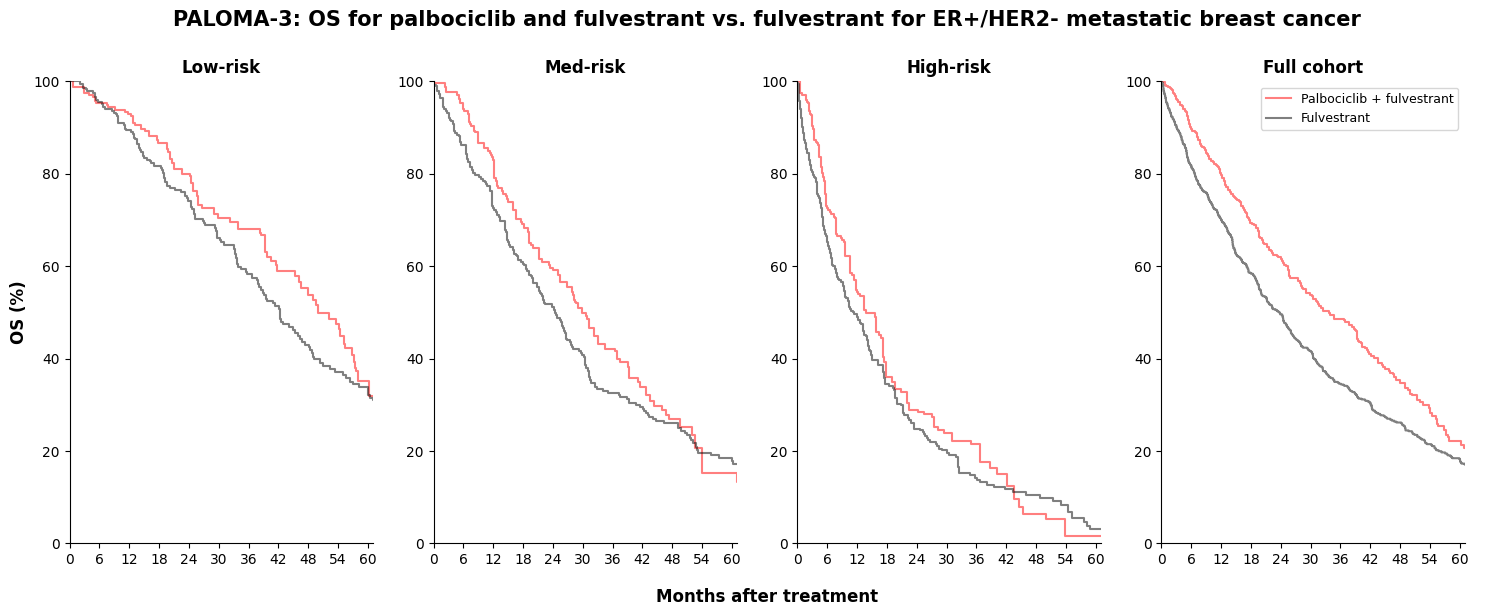

In [223]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pfulv_paloma3_iptw.timeline, kmf_low_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_fulv_paloma3_iptw.timeline, kmf_low_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pfulv_paloma3_iptw.timeline, kmf_med_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_fulv_paloma3_iptw.timeline, kmf_med_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pfulv_paloma3_iptw.timeline, kmf_high_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_fulv_paloma3_iptw.timeline, kmf_high_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pfulv_paloma3_iptw.timeline, kmf_all_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Palbociclib + fulvestrant')

plt.step(kmf_all_fulv_paloma3_iptw.timeline, kmf_all_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Fulvestrant')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-3: OS for palbociclib and fulvestrant vs. fulvestrant for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [224]:
pfulv_paloma3_24_os = psurv_t(kmf_low_pfulv_paloma3_iptw,
                              kmf_med_pfulv_paloma3_iptw,
                              kmf_high_pfulv_paloma3_iptw,
                              24)

fulv_paloma3_24_os = psurv_t(kmf_low_fulv_paloma3_iptw,
                             kmf_med_fulv_paloma3_iptw,
                             kmf_high_fulv_paloma3_iptw,
                             24)

pfulv_paloma3_36_os = psurv_t(kmf_low_pfulv_paloma3_iptw,
                              kmf_med_pfulv_paloma3_iptw,
                              kmf_high_pfulv_paloma3_iptw,
                              36)

fulv_paloma3_36_os = psurv_t(kmf_low_fulv_paloma3_iptw,
                             kmf_med_fulv_paloma3_iptw,
                             kmf_high_fulv_paloma3_iptw,
                             36)

pfulv_paloma3_median_os = mos(kmf_low_pfulv_paloma3_iptw,
                              kmf_med_pfulv_paloma3_iptw,
                              kmf_high_pfulv_paloma3_iptw,
                              kmf_all_pfulv_paloma3_iptw)

fulv_paloma3_median_os = mos(kmf_low_fulv_paloma3_iptw,
                              kmf_med_fulv_paloma3_iptw,
                              kmf_high_fulv_paloma3_iptw,
                              kmf_all_fulv_paloma3_iptw)

In [225]:
print('All, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[3], 3))
print('All, fulvestrant: ',truncate(fulv_paloma3_median_os[3], 3))

print('Low, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[0], 3))
print('Low, fulvestrant: ',truncate(fulv_paloma3_median_os[0], 3))

print('Med, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[1], 3))
print('Med, fulvestrant: ',truncate(fulv_paloma3_median_os[1], 3))

print('High, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[2], 3))
print('High, fulvestrant: ',truncate(fulv_paloma3_median_os[2], 3))

All, palbo + fulvestrant:  33.833
All, fulvestrant:  23.866
Low, palbo + fulvestrant:  50.066
Low, fulvestrant:  42.333
Med, palbo + fulvestrant:  30.566
Med, fulvestrant:  24.6
High, palbo + fulvestrant:  14.366
High, fulvestrant:  11.433


In [226]:
pfulv_paloma3_low_24_ci = psurv_ci(kmf_low_pfulv_paloma3_iptw, 24)
pfulv_paloma3_med_24_ci = psurv_ci(kmf_med_pfulv_paloma3_iptw, 24)
pfulv_paloma3_high_24_ci = psurv_ci(kmf_high_pfulv_paloma3_iptw, 24)

y_error_pfulv_paloma3_24 = y_error(pfulv_paloma3_low_24_ci,
                                   pfulv_paloma3_med_24_ci,
                                   pfulv_paloma3_high_24_ci,
                                   pfulv_paloma3_24_os)

In [227]:
fulv_paloma3_low_24_ci = psurv_ci(kmf_low_fulv_paloma3_iptw, 24)
fulv_paloma3_med_24_ci = psurv_ci(kmf_med_fulv_paloma3_iptw, 24)
fulv_paloma3_high_24_ci = psurv_ci(kmf_high_fulv_paloma3_iptw, 24)

y_error_fulv_paloma3_24 = y_error(fulv_paloma3_low_24_ci,
                                  fulv_paloma3_med_24_ci,
                                  fulv_paloma3_high_24_ci,
                                  fulv_paloma3_24_os)

In [228]:
pfulv_paloma3_low_36_ci = psurv_ci(kmf_low_pfulv_paloma3_iptw, 36)
pfulv_paloma3_med_36_ci = psurv_ci(kmf_med_pfulv_paloma3_iptw, 36)
pfulv_paloma3_high_36_ci = psurv_ci(kmf_high_pfulv_paloma3_iptw, 36)

y_error_pfulv_paloma3_36 = y_error(pfulv_paloma3_low_36_ci,
                                   pfulv_paloma3_med_36_ci,
                                   pfulv_paloma3_high_36_ci,
                                   pfulv_paloma3_36_os)

In [229]:
fulv_paloma3_low_36_ci = psurv_ci(kmf_low_fulv_paloma3_iptw, 36)
fulv_paloma3_med_36_ci = psurv_ci(kmf_med_fulv_paloma3_iptw, 36)
fulv_paloma3_high_36_ci = psurv_ci(kmf_high_fulv_paloma3_iptw, 36)

y_error_fulv_paloma3_36 = y_error(fulv_paloma3_low_36_ci,
                                  fulv_paloma3_med_36_ci,
                                  fulv_paloma3_high_36_ci,
                                  fulv_paloma3_36_os)

In [230]:
pfulv_paloma3_low_mos_ci = mos_ci(kmf_low_pfulv_paloma3_iptw)
pfulv_paloma3_med_mos_ci = mos_ci(kmf_med_pfulv_paloma3_iptw)
pfulv_paloma3_high_mos_ci = mos_ci(kmf_high_pfulv_paloma3_iptw)

y_error_pfulv_paloma3_mos = y_error(pfulv_paloma3_low_mos_ci,
                                    pfulv_paloma3_med_mos_ci,
                                    pfulv_paloma3_high_mos_ci,
                                    pfulv_paloma3_median_os)

In [231]:
fulv_paloma3_low_mos_ci = mos_ci(kmf_low_fulv_paloma3_iptw)
fulv_paloma3_med_mos_ci = mos_ci(kmf_med_fulv_paloma3_iptw)
fulv_paloma3_high_mos_ci = mos_ci(kmf_high_fulv_paloma3_iptw)

y_error_fulv_paloma3_mos = y_error(fulv_paloma3_low_mos_ci,
                                   fulv_paloma3_med_mos_ci,
                                   fulv_paloma3_high_mos_ci,
                                   fulv_paloma3_median_os)

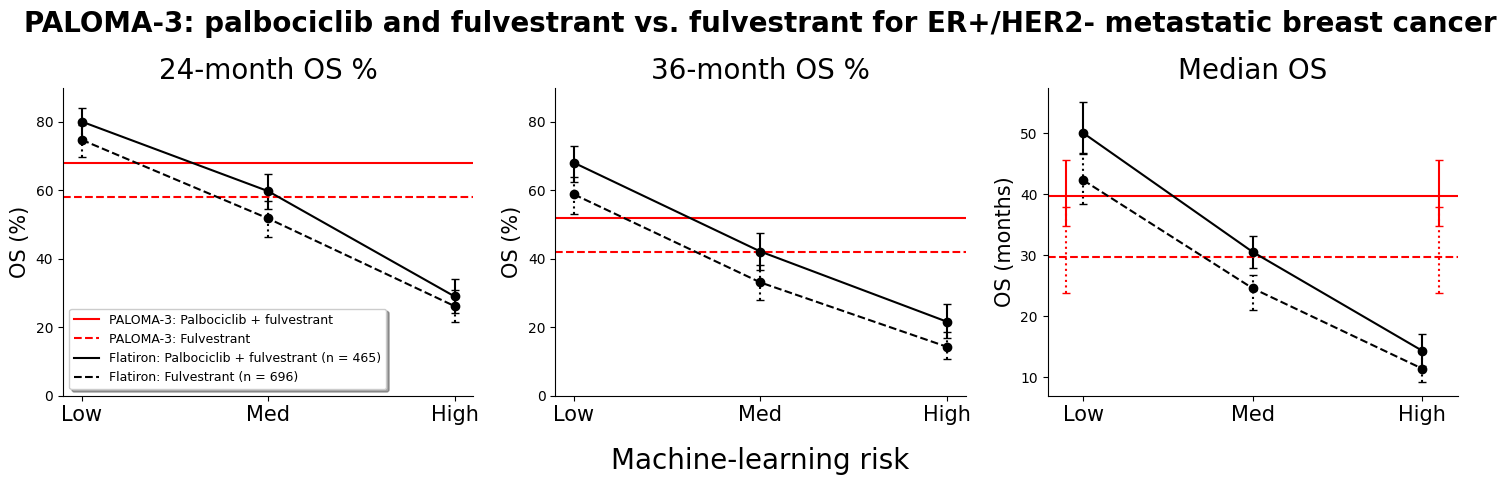

In [232]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 24 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pfulv_paloma3_24_os, yerr = y_error_pfulv_paloma3_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 68, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, fulv_paloma3_24_os, yerr = y_error_fulv_paloma3_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 58, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 36 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pfulv_paloma3_36_os, yerr = y_error_pfulv_paloma3_36, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 52, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, fulv_paloma3_36_os, yerr = y_error_fulv_paloma3_36, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 42, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('36-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pfulv_paloma3_median_os[0:3], yerr = y_error_pfulv_paloma3_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 39.7, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 39.7, yerr=[np.array([39.7-34.8]), np.array([45.7-39.7])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, fulv_paloma3_median_os[0:3], yerr = y_error_fulv_paloma3_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 29.7, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 29.7, yerr=[np.array([29.7-23.8]), np.array([37.9-29.7])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('PALOMA-3: palbociclib and fulvestrant vs. fulvestrant for ER+/HER2- metastatic breast cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'PALOMA-3: Palbociclib + fulvestrant'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'PALOMA-3: Fulvestrant'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Palbociclib + fulvestrant (n = {})'.format(paloma3.query('pfulv == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Fulvestrant (n = {})'.format(paloma3.query('pfulv == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

plt.savefig('paloma3_summary_rc.png', bbox_inches = 'tight')

plt.show()

### CLEOPATRA: pertuzumab, trastuzumab, and docetaxel in HER2-positive metastatic breast cancer

**INCLUSION**
* Untreated metastatic breast cancer
* Received first line pertuzumab, trastuzumab, and docetaxel/paclitaxel or first line trastuzumab + docetaxel/paclitaxel 
* First line of hormonal treatment is allowed
* HER-2 positive within (+30, -inf) of receipt of treatment 

#### First line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [233]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [234]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [235]:
tpdp = [
    'Docetaxel,Pertuzumab,Trastuzumab',
    'Docetaxel,Pertuzumab,Trastuzumab-Anns',
    'Docetaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel,Pertuzumab,Trastuzumab',
    'Paclitaxel,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Qyyp']

tpdp_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [236]:
tpdp_fl.loc[:, 'tpdp'] = 1

In [237]:
row_ID(tpdp_fl)

(1219, 1219)

In [238]:
tpd = [
    'Docetaxel,Trastuzumab',
    'Docetaxel,Trastuzumab-Anns',
    'Docetaxel,Trastuzumab-Qyyp',
    'Paclitaxel,Trastuzumab',
    'Paclitaxel,Trastuzumab-Anns',
    'Paclitaxel,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Trastuzumab',
    'Paclitaxel Protein-Bound,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Trastuzumab-Qyyp'] 

tpd_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [239]:
tpd_fl.loc[:, 'tpdp'] = 0

In [240]:
row_ID(tpdp_fl)

(1219, 1219)

#### First line endocrine therapy, second line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [241]:
all_treatment = line_therapy.LineName.unique()

In [242]:
treatment_list = []
for trt in all_treatment:
    treatment_list.extend(trt.split(","))

In [243]:
unique = list(dict.fromkeys(treatment_list))

In [244]:
et = [
    'Anastrozole',
    'Letrozole',
    'Exemestane',
    'Tamoxifen',
    'Leuprolide',
    'Goserelin',
    'Triptorelin']

In [245]:
unique.remove('Anastrozole')
unique.remove('Letrozole')
unique.remove('Exemestane')
unique.remove('Tamoxifen')
unique.remove('Leuprolide')
unique.remove('Goserelin')
unique.remove('Triptorelin')

In [246]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [247]:
(
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .LineName.value_counts().head(10)
)

Anastrozole               2943
Letrozole                 2536
Tamoxifen                 1305
Exemestane                 780
Leuprolide                  77
Goserelin                   60
Leuprolide,Tamoxifen        56
Letrozole,Leuprolide        40
Goserelin,Tamoxifen         36
Anastrozole,Leuprolide      35
Name: LineName, dtype: int64

In [248]:
et_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .PatientID
)

In [249]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2'))

In [250]:
et_tpdp = (
    line_therapy_sec
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [251]:
et_tpdp.loc[:, 'tpdp'] = 1

In [252]:
row_ID(et_tpdp)

(79, 79)

In [253]:
et_tpd = (
    line_therapy_sec
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [254]:
et_tpd.loc[:, 'tpdp'] = 0

In [255]:
row_ID(et_tpd)

(5, 5)

In [256]:
cleopatra_p = pd.concat([tpdp_fl, et_tpdp])

In [257]:
row_ID(cleopatra_p)

(1298, 1298)

In [258]:
cleopatra_np = pd.concat([tpd_fl, et_tpd])

In [259]:
row_ID(cleopatra_np)

(184, 184)

In [260]:
cleopatra = pd.concat([cleopatra_p, cleopatra_np])

In [261]:
row_ID(cleopatra)

(1482, 1482)

In [262]:
cleopatra = pd.merge(cleopatra, df_full, on = 'PatientID', how = 'inner')

In [263]:
row_ID(cleopatra)

(1482, 1482)

In [264]:
cleopatra['StartDate'] = pd.to_datetime(cleopatra['StartDate'])

#### HER-2 positive

In [265]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [266]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(cleopatra['PatientID'])]

In [267]:
row_ID(biomarkers)

(10765, 1482)

In [268]:
biomarkers = pd.merge(biomarkers, cleopatra[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [269]:
row_ID(biomarkers)

(10765, 1482)

In [270]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [271]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [272]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [273]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [274]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [275]:
her2_rel = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == @her2_rel')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [276]:
row_ID(her2_status)

(1377, 1377)

In [277]:
cleopatra = pd.merge(cleopatra, her2_status, on  = 'PatientID', how = 'left')

In [278]:
row_ID(cleopatra)

(1482, 1482)

In [279]:
her2_pos = ['IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

cleopatra = (
    cleopatra
    .query('her2== @her2_pos')
)

In [280]:
row_ID(cleopatra)

(1296, 1296)

#### Time from treatment to death or censor 

In [281]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [282]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [283]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [284]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [285]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [286]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [287]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [288]:
row_ID(mortality)

(31677, 31677)

In [289]:
cleopatra = pd.merge(cleopatra, mortality, on = 'PatientID', how = 'left')

In [290]:
row_ID(cleopatra)

(1296, 1296)

In [291]:
conditions = [
    (cleopatra['death_status'] == 1),
    (cleopatra['death_status'] == 0)]

choices = [
    (cleopatra['death_date'] - cleopatra['StartDate']).dt.days,
    (cleopatra['last_activity'] - cleopatra['StartDate']).dt.days]

cleopatra.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [292]:
cleopatra = cleopatra.query('timerisk_treatment >= 0')

#### Patient count 

In [293]:
low_cutoff_cleopatra = cleopatra.risk_score.quantile(1/3)

In [294]:
high_cutoff_cleopatra = cleopatra.risk_score.quantile(2/3)

In [295]:
print('Pertuzumab + trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 1').shape[0])
print('High risk:', cleopatra.query('tpdp == 1').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 1').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 1').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Pertuzumab + trastuzumab + docetaxel/paclitaxel total: 1151
High risk: 375
Med risk: 390
Low risk: 386


In [296]:
print('Trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 0').shape[0])
print('High risk:', cleopatra.query('tpdp == 0').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 0').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 0').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Trastuzumab + docetaxel/paclitaxel total: 143
High risk: 57
Med risk: 41
Low risk: 45


In [297]:
risk_cutoff_breast.loc['cleopatra'] = [low_cutoff_cleopatra, high_cutoff_cleopatra]

In [298]:
risk_cutoff_breast

,low,high
paloma2,-0.740498,-0.130034
paloma3,-0.674012,-0.024017
cleopatra,-0.828093,-0.084191


In [299]:
risk_cutoff_breast.to_csv('risk_cutoff_breast.csv', index = True)

#### Survival curves with covaraite balancing 

In [300]:
conditions = [
    (cleopatra['thorax_met'] == 1) |
    (cleopatra['liver_met'] == 1) |
    (cleopatra['cns_met'] == 1) |
    (cleopatra['peritoneum_met'] == 1) |
    (cleopatra['other_met'] == 1),
    (cleopatra['bone_met'] == 0) &
    (cleopatra['thorax_met'] == 0) &
    (cleopatra['lymph_met'] == 0) &
    (cleopatra['liver_met'] == 0) &
    (cleopatra['cns_met'] == 0) &
    (cleopatra['skin_met'] == 0) &
    (cleopatra['peritoneum_met'] == 0) &
    (cleopatra['other_met'] == 0)
]

choices = ['visceral', 'unknown']

cleopatra['met_site'] = np.select(conditions, choices, default = 'nonvisceral')

In [301]:
cleopatra['met_cat'] = pd.cut(cleopatra['met_year'],
                              bins = [2010, 2016, float('inf')],
                              labels = ['11-16', '17-22'])

In [302]:
conditions = [
    ((cleopatra['ecog_diagnosis'] == "1.0") | (cleopatra['ecog_diagnosis'] == "0.0")),  
    ((cleopatra['ecog_diagnosis'] == "2.0") | (cleopatra['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

cleopatra['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [303]:
conditions = [
    ((cleopatra['ses'] == 1) | (cleopatra['ses'] == 2) | (cleopatra['ses'] == 3)), 
    ((cleopatra['ses'] == 4) | (cleopatra['ses'] == 5))
]

choices = ['lt_4', 'gte_4']

cleopatra['ses_cat'] = np.select(conditions, choices, default = 'unknown')

In [304]:
cleopatra['race_cat'] = np.where(cleopatra['race'] == "White", 1, 0)

In [305]:
cleopatra = cleopatra.set_index('PatientID')

In [306]:
cleopatra_iptw = cleopatra.filter(items = ['death_status',
                                           'timerisk_treatment',
                                           'tpdp',
                                           'age',
                                           'gender',
                                           'race_cat',
                                           'p_type',
                                           'delta_met_diagnosis',
                                           'met_cat',
                                           'ses_cat',
                                           'ecog_2',
                                           'risk_score'])

In [307]:
cleopatra_iptw.dtypes

death_status               bool
timerisk_treatment      float64
tpdp                      int64
age                       int64
gender                   object
race_cat                  int64
p_type                   object
delta_met_diagnosis       int64
met_cat                category
ses_cat                  object
ecog_2                   object
risk_score              float64
dtype: object

In [308]:
to_be_categorical = list(cleopatra_iptw.select_dtypes(include = ['object']).columns)

In [309]:
to_be_categorical

['gender', 'p_type', 'ses_cat', 'ecog_2']

In [310]:
to_be_categorical.append('met_cat')

In [311]:
to_be_categorical.append('race_cat')

In [312]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    cleopatra_iptw[x] = cleopatra_iptw[x].astype('category')

In [313]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [314]:
# List of categorical features.
categorical_features = list(cleopatra_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [315]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [316]:
cleopatra_iptw_low = (
    cleopatra_iptw
    .query('risk_score <= @low_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_med = (
    cleopatra_iptw
    .query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_high = (
    cleopatra_iptw
    .query('risk_score >= @high_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_all = (
    cleopatra_iptw
    .drop(columns = ['risk_score']))

In [317]:
cleopatra_low_x = preprocessor.fit_transform(cleopatra_iptw_low.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat',
                                                                                'ecog_2']))

cleopatra_med_x = preprocessor.fit_transform(cleopatra_iptw_med.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat', 
                                                                                'ecog_2']))

cleopatra_high_x = preprocessor.fit_transform(cleopatra_iptw_high.filter(items = ['age',
                                                                                  'gender',
                                                                                  'race_cat',
                                                                                  'p_type',
                                                                                  'delta_met_diagnosis',
                                                                                  'met_cat',
                                                                                  'ses_cat', 
                                                                                  'ecog_2']))

cleopatra_all_x = preprocessor.fit_transform(cleopatra_iptw_all.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat',
                                                                                'ecog_2']))

In [318]:
lr_cleopatra_low = LogisticRegression(max_iter = 1000)
lr_cleopatra_low.fit(cleopatra_low_x, cleopatra_iptw_low['tpdp'])

LogisticRegression(max_iter=1000)

In [319]:
lr_cleopatra_med = LogisticRegression(max_iter = 1000)
lr_cleopatra_med.fit(cleopatra_med_x, cleopatra_iptw_med['tpdp'])

LogisticRegression(max_iter=1000)

In [320]:
lr_cleopatra_high = LogisticRegression(max_iter = 1000)
lr_cleopatra_high.fit(cleopatra_high_x, cleopatra_iptw_high['tpdp'])

LogisticRegression(max_iter=1000)

In [321]:
lr_cleopatra_all = LogisticRegression(max_iter = 1000)
lr_cleopatra_all.fit(cleopatra_all_x, cleopatra_iptw_all['tpdp'])

LogisticRegression(max_iter=1000)

In [322]:
pred_low = lr_cleopatra_low.predict_proba(cleopatra_low_x)
pred_med = lr_cleopatra_med.predict_proba(cleopatra_med_x)
pred_high = lr_cleopatra_high.predict_proba(cleopatra_high_x)
pred_all = lr_cleopatra_all.predict_proba(cleopatra_all_x)

In [323]:
cleopatra_iptw_low['ps'] = pred_low[:, 1]
cleopatra_iptw_med['ps'] = pred_med[:, 1]
cleopatra_iptw_high['ps'] = pred_high[:, 1]
cleopatra_iptw_all['ps'] = pred_all[:, 1]

In [324]:
cleopatra_iptw_low['weight'] = (
    np.where(cleopatra_iptw_low['tpdp'] == 1, 1/cleopatra_iptw_low['ps'], 1/(1 - cleopatra_iptw_low['ps'])))

cleopatra_iptw_med['weight'] = (
    np.where(cleopatra_iptw_med['tpdp'] == 1, 1/cleopatra_iptw_med['ps'], 1/(1 - cleopatra_iptw_med['ps'])))

cleopatra_iptw_high['weight'] = (
    np.where(cleopatra_iptw_high['tpdp'] == 1, 1/cleopatra_iptw_high['ps'], 1/(1 - cleopatra_iptw_high['ps'])))

cleopatra_iptw_all['weight'] = (
    np.where(cleopatra_iptw_all['tpdp'] == 1, 1/cleopatra_iptw_all['ps'], 1/(1 - cleopatra_iptw_all['ps'])))

In [325]:
# Low KM curves
kmf_low_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_low_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_low_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_low.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_low.query('tpdp == 1')['death_status'],
    weights = cleopatra_iptw_low.query('tpdp == 1')['weight'])

kmf_low_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_low.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_low.query('tpdp == 0')['death_status'],
    weights = cleopatra_iptw_low.query('tpdp == 0')['weight'])

# Med KM curves
kmf_med_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_med_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_med_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_med.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_med.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_med.query('tpdp == 1')['weight'])

kmf_med_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_med.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_med.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_med.query('tpdp == 0')['weight'])

# High KM curves 
kmf_high_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_high_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_high_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_high.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_high.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_high.query('tpdp == 1')['weight'])

kmf_high_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_high.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_high.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_high.query('tpdp == 0')['weight'])

# All KM curves 
kmf_all_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_all_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_all_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_all.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_all.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_all.query('tpdp == 1')['weight'])

kmf_all_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_all.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_all.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_all.query('tpdp == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1263.51 total observations, 427.177 right-censored observations>

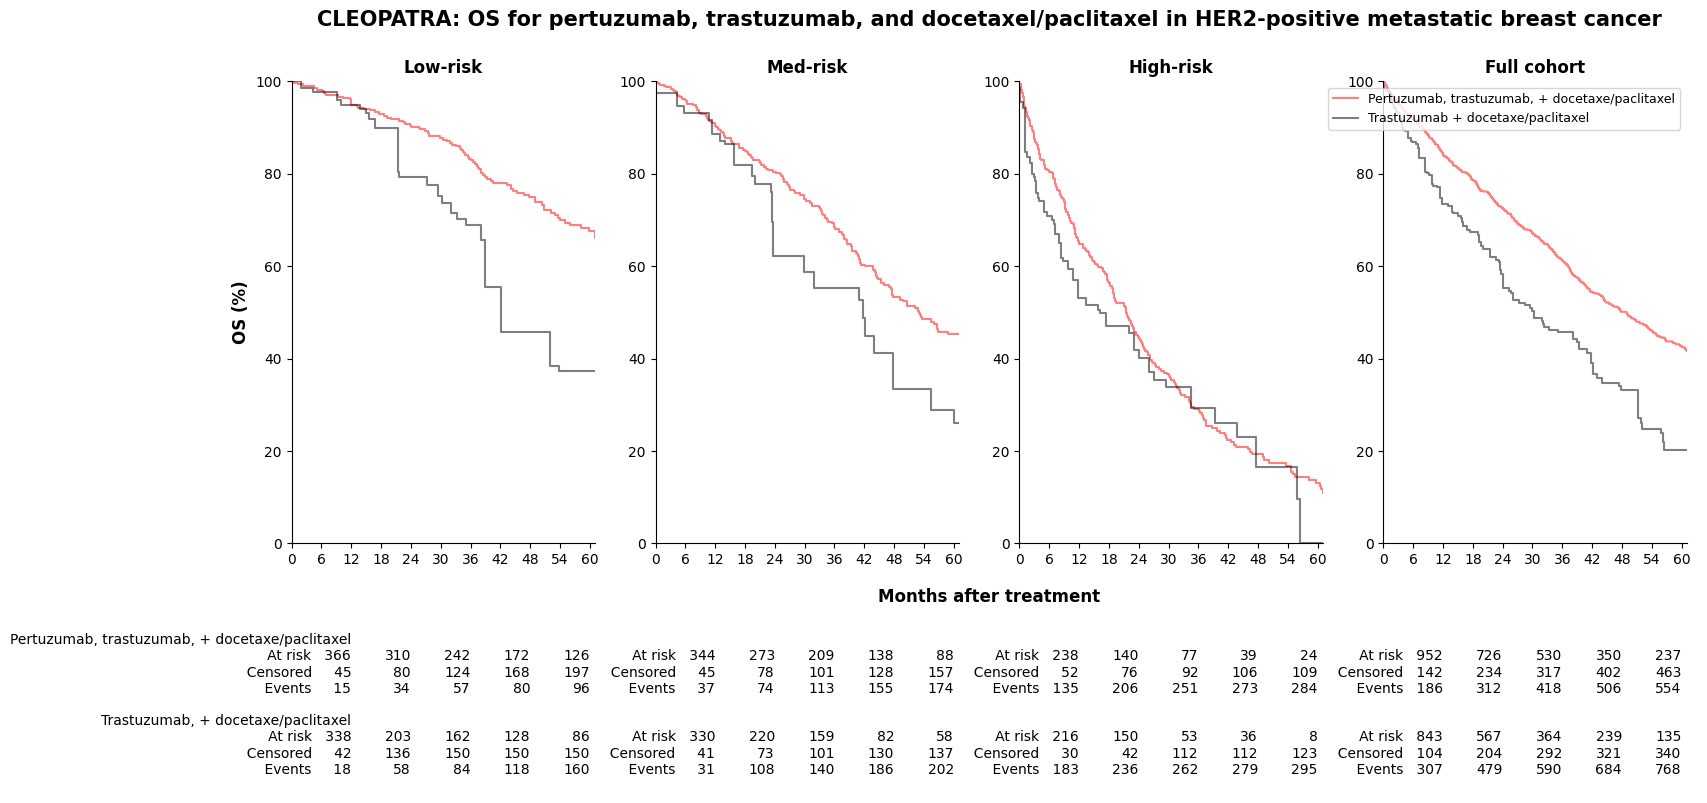

In [326]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_tpdp_cleopatra_iptw.timeline, kmf_low_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_tdp_cleopatra_iptw.timeline, kmf_low_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_tpdp_cleopatra_iptw, kmf_low_tdp_cleopatra_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = ['Pertuzumab, trastuzumab, + docetaxe/paclitaxel', 'Trastuzumab, + docetaxe/paclitaxel'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_tpdp_cleopatra_iptw.timeline, kmf_med_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_tdp_cleopatra_iptw.timeline, kmf_med_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_tpdp_cleopatra_iptw, kmf_med_tdp_cleopatra_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_tpdp_cleopatra_iptw.timeline, kmf_high_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_tdp_cleopatra_iptw.timeline, kmf_high_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_tpdp_cleopatra_iptw, kmf_high_tdp_cleopatra_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_tpdp_cleopatra_iptw.timeline, kmf_all_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pertuzumab, trastuzumab, + docetaxe/paclitaxel')

plt.step(kmf_all_tdp_cleopatra_iptw.timeline, kmf_all_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Trastuzumab + docetaxe/paclitaxel')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

add_at_risk_counts(kmf_all_tpdp_cleopatra_iptw, kmf_all_tdp_cleopatra_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CLEOPATRA: OS for pertuzumab, trastuzumab, and docetaxel/paclitaxel in HER2-positive metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plos

In [327]:
tpdp_cleopatra_24_os = psurv_t(kmf_low_tpdp_cleopatra_iptw,
                               kmf_med_tpdp_cleopatra_iptw,
                               kmf_high_tpdp_cleopatra_iptw,
                               24)

tdp_cleopatra_24_os = psurv_t(kmf_low_tdp_cleopatra_iptw,
                              kmf_med_tdp_cleopatra_iptw,
                              kmf_high_tdp_cleopatra_iptw,
                              24)

tpdp_cleopatra_36_os = psurv_t(kmf_low_tpdp_cleopatra_iptw,
                               kmf_med_tpdp_cleopatra_iptw,
                               kmf_high_tpdp_cleopatra_iptw,
                               36)

tdp_cleopatra_36_os = psurv_t(kmf_low_tdp_cleopatra_iptw,
                              kmf_med_tdp_cleopatra_iptw,
                              kmf_high_tdp_cleopatra_iptw,
                              36)

tpdp_cleopatra_median_os = mos(kmf_low_tpdp_cleopatra_iptw,
                               kmf_med_tpdp_cleopatra_iptw,
                               kmf_high_tpdp_cleopatra_iptw,
                               kmf_all_tpdp_cleopatra_iptw)

tdp_cleopatra_median_os = mos(kmf_low_tdp_cleopatra_iptw,
                              kmf_med_tdp_cleopatra_iptw,
                              kmf_high_tdp_cleopatra_iptw,
                              kmf_all_tdp_cleopatra_iptw)

In [328]:
print('All, TPD/P: ',truncate(tpdp_cleopatra_median_os[3], 3))
print('All, TD/P: ',truncate(tdp_cleopatra_median_os[3], 3))

print('Low, TPD/P: ',truncate(tpdp_cleopatra_median_os[0], 3))
print('Low, TD/P: ',truncate(tdp_cleopatra_median_os[0], 3))

print('Med, TPD/P: ',truncate(tpdp_cleopatra_median_os[1], 3))
print('Med, TD/P: ',truncate(tdp_cleopatra_median_os[1], 3))

print('High, TPD/P: ',truncate(tpdp_cleopatra_median_os[2], 3))
print('High, TD/P: ',truncate(tdp_cleopatra_median_os[2], 3))

All, TPD/P:  48.966
All, TD/P:  31.833
Low, TPD/P:  90.6
Low, TD/P:  51.9
Med, TPD/P:  53.133
Med, TD/P:  42.2
High, TPD/P:  21.6
High, TD/P:  17.466


In [329]:
tpdp_cleopatra_low_24_ci = psurv_ci(kmf_low_tpdp_cleopatra_iptw, 24)
tpdp_cleopatra_med_24_ci = psurv_ci(kmf_med_tpdp_cleopatra_iptw, 24)
tpdp_cleopatra_high_24_ci = psurv_ci(kmf_high_tpdp_cleopatra_iptw, 24)

y_error_tpdp_cleopatra_24 = y_error(tpdp_cleopatra_low_24_ci,
                                    tpdp_cleopatra_med_24_ci,
                                    tpdp_cleopatra_high_24_ci,
                                    tpdp_cleopatra_24_os)

In [330]:
tdp_cleopatra_low_24_ci = psurv_ci(kmf_low_tdp_cleopatra_iptw, 24)
tdp_cleopatra_med_24_ci = psurv_ci(kmf_med_tdp_cleopatra_iptw, 24)
tdp_cleopatra_high_24_ci = psurv_ci(kmf_high_tdp_cleopatra_iptw, 24)

y_error_tdp_cleopatra_24 = y_error(tdp_cleopatra_low_24_ci,
                                   tdp_cleopatra_med_24_ci,
                                   tdp_cleopatra_high_24_ci,
                                   tdp_cleopatra_24_os)

In [331]:
tpdp_cleopatra_low_36_ci = psurv_ci(kmf_low_tpdp_cleopatra_iptw, 36)
tpdp_cleopatra_med_36_ci = psurv_ci(kmf_med_tpdp_cleopatra_iptw, 36)
tpdp_cleopatra_high_36_ci = psurv_ci(kmf_high_tpdp_cleopatra_iptw, 36)

y_error_tpdp_cleopatra_36 = y_error(tpdp_cleopatra_low_36_ci,
                                    tpdp_cleopatra_med_36_ci,
                                    tpdp_cleopatra_high_36_ci,
                                    tpdp_cleopatra_36_os)

In [332]:
tdp_cleopatra_low_36_ci = psurv_ci(kmf_low_tdp_cleopatra_iptw, 36)
tdp_cleopatra_med_36_ci = psurv_ci(kmf_med_tdp_cleopatra_iptw, 36)
tdp_cleopatra_high_36_ci = psurv_ci(kmf_high_tdp_cleopatra_iptw, 36)

y_error_tdp_cleopatra_36 = y_error(tdp_cleopatra_low_36_ci,
                                   tdp_cleopatra_med_36_ci,
                                   tdp_cleopatra_high_36_ci,
                                   tdp_cleopatra_36_os)

In [333]:
tpdp_cleopatra_low_mos_ci = mos_ci(kmf_low_tpdp_cleopatra_iptw)
tpdp_cleopatra_med_mos_ci = mos_ci(kmf_med_tpdp_cleopatra_iptw)
tpdp_cleopatra_high_mos_ci = mos_ci(kmf_high_tpdp_cleopatra_iptw)

y_error_tpdp_cleopatra_mos = y_error(tpdp_cleopatra_low_mos_ci,
                                     tpdp_cleopatra_med_mos_ci,
                                     tpdp_cleopatra_high_mos_ci,
                                     tpdp_cleopatra_median_os)

In [334]:
tdp_cleopatra_low_mos_ci = mos_ci(kmf_low_tdp_cleopatra_iptw)
tdp_cleopatra_med_mos_ci = mos_ci(kmf_med_tdp_cleopatra_iptw)
tdp_cleopatra_high_mos_ci = mos_ci(kmf_high_tdp_cleopatra_iptw)

y_error_tdp_cleopatra_mos = y_error(tdp_cleopatra_low_mos_ci,
                                    tdp_cleopatra_med_mos_ci,
                                    tdp_cleopatra_high_mos_ci,
                                    tdp_cleopatra_median_os)

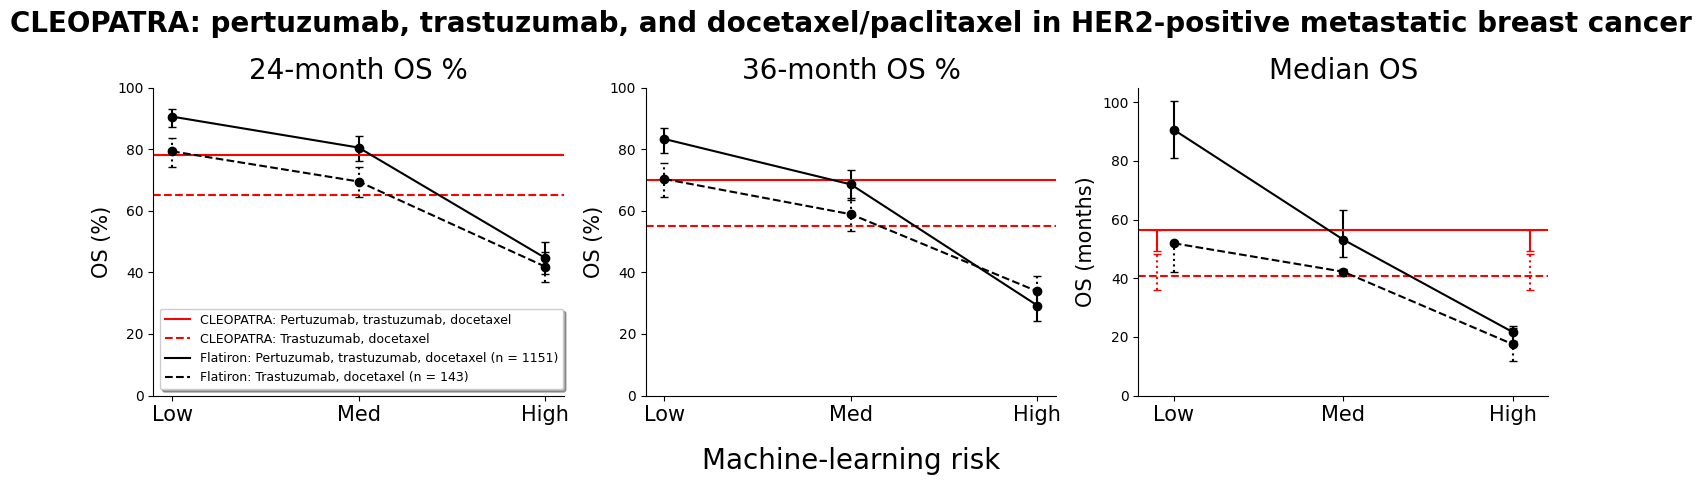

In [335]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 24 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, tpdp_cleopatra_24_os, yerr = y_error_tpdp_cleopatra_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 78, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, tdp_cleopatra_24_os, yerr = y_error_tdp_cleopatra_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 65, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 36 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, tpdp_cleopatra_36_os, yerr = y_error_tpdp_cleopatra_36, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 70, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, tdp_cleopatra_36_os, yerr = y_error_tdp_cleopatra_36, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 55, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('36-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, tpdp_cleopatra_median_os[0:3], yerr = y_error_tpdp_cleopatra_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 56.5, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 56.5, yerr=[np.array([56.5-49.3]), np.array([56.5-56.5])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, tdp_cleopatra_median_os[0:3], yerr = y_error_tdp_cleopatra_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 40.8, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 40.8, yerr=[np.array([40.8-35.8]), np.array([48.3-40.8])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylim(0, 105)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('CLEOPATRA: pertuzumab, trastuzumab, and docetaxel/paclitaxel in HER2-positive metastatic breast cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'CLEOPATRA: Pertuzumab, trastuzumab, docetaxel'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'CLEOPATRA: Trastuzumab, docetaxel'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pertuzumab, trastuzumab, docetaxel (n = {})'.format(cleopatra.query('tpdp == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Trastuzumab, docetaxel (n = {})'.format(cleopatra.query('tpdp == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

#plt.savefig('cleopatra_summary_rc.png', bbox_inches = 'tight')

plt.show()